In [1]:
import pandas as pd
import plotnine as pn
import numpy as np
import shap
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.inspection import plot_partial_dependence,permutation_importance

import time
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

/apps/python/3.8/lib/python3.8/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.


Read in dataframe, only get upper and lower 20th percentile

In [2]:
df = pd.read_csv('SW_liminal_Dec17.csv')
# convert to top 20th and lower 80th percentiles
p_20 = df.SWI.quantile(0.2)
p_80 = df.SWI.quantile(0.8)
df = df[df.SWI.gt(p_80) | df.SWI.lt(p_20)]

# drop unncessary columns
df = df.drop(['x', 'y','code_ice', 'code_overburden', 'thickness_number', 'permafrost'],\
             axis=1)
df= df.drop(['medium_glacial_lakes', 'medium_peat_lakes',\
            'medium_yedoma_lakes', 'small_glacial_lakes',\
              'small_peat_lakes', 'small_yedoma_lakes'],axis=1)

df= df.drop(['GSrain', 'EVI', 'falltemp', 'fallsnow', 'longwintersnow', 'longwintertemp',\
            'onset', 'springsnow', 'springtemp', 'wintersnow', 'wintertemp', 'summertemp'],axis=1)


# define x and y
x = df.drop(['SWI'],axis=1)             
          
y = df['SWI']

print(list(df.columns))

['annualtemp', 'evaporation', 'fallrain', 'lakiness', 'meltout', 'meltwater', 'springrain', 'summerrain', 'SWI', 'ice_number']


In [ ]:
SET UP THE MODEL

In [9]:
# define the grid of values to search
grid = dict()

grid['max_iter'] = [3000]
grid['learning_rate'] = [0.1,0.2,0.3,0.4]
grid['max_depth'] = [ 100,120,150,200,220]
grid['max_bins'] = [60,80,100,120]  
grid['max_leaf_nodes'] =[ None]


grid_search = GridSearchCV(estimator=HistGradientBoostingRegressor(),
                           param_grid=grid, n_jobs=-1, cv=10)
                           
grid_result = grid_search.fit(x, y)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.576538 using {'learning_rate': 0.2, 'max_bins': 80, 'max_depth': 200, 'max_iter': 3000, 'max_leaf_nodes': None}


In [ ]:
RUN THE MODEL

In [10]:
finalmodel = HistGradientBoostingRegressor(
                max_leaf_nodes= None,
                max_bins= 80,
                max_iter = 3000,
                learning_rate=0.2,
                max_depth=200)

## fit the model
finalmodel.fit(x, y)

HistGradientBoostingRegressor(learning_rate=0.2, max_bins=80, max_depth=200,
                              max_iter=3000, max_leaf_nodes=None)

In [ ]:
PERMUTATION IMPORTANCE

In [21]:
pi = permutation_importance(finalmodel, x, y, n_repeats=100,
                            random_state=42, n_jobs=-1)

sorted_idx = pi.importances_mean.argsort()
sorted_names = np.array(list(x.columns))[sorted_idx]



permimport = pd.DataFrame({'mean' : pi.importances_mean[sorted_idx].T,\
                          'stdev' : pi.importances_std[sorted_idx].T,\
                           'variable': sorted_names})


In [22]:
permimport

,mean,stdev,variable
0,0.064434,0.001205,ice_number
1,0.120992,0.002094,evaporation
2,0.123245,0.001952,meltout
3,0.157224,0.001898,summerrain
4,0.256705,0.003673,meltwater
5,0.332572,0.003999,lakiness
6,0.337472,0.003964,springrain
7,0.401230,0.004385,fallrain
8,0.647109,0.006109,annualtemp


In [ ]:
SHAPLEY VALUES

In [13]:
shapexplainer = shap.TreeExplainer(finalmodel)

shap_values = shapexplainer.shap_values(x)

# save values as a dataframe
shapdf = pd.DataFrame(shap_values,columns=x.columns)



In [23]:
shap_df = shapdf.abs().sum().to_frame(name='sv').reset_index().rename(columns = {'index':'variable'})
shap_df = shap_df.sort_values('sv')
shap_df['relative'] = shap_df['sv']/shap_df['sv'].max()
shap_df['method'] = "Shapley Value"
permimport['relative'] = permimport['mean']/permimport['mean'].max()
permimport['method'] = "Permutation Importance"

full = pd.concat([shap_df, permimport])
permimport

,mean,stdev,variable,relative,method
0,0.064434,0.001205,ice_number,0.099572,Permutation Importance
1,0.120992,0.002094,evaporation,0.186973,Permutation Importance
2,0.123245,0.001952,meltout,0.190455,Permutation Importance
3,0.157224,0.001898,summerrain,0.242964,Permutation Importance
4,0.256705,0.003673,meltwater,0.396696,Permutation Importance
5,0.332572,0.003999,lakiness,0.513935,Permutation Importance
6,0.337472,0.003964,springrain,0.521507,Permutation Importance
7,0.401230,0.004385,fallrain,0.620034,Permutation Importance
8,0.647109,0.006109,annualtemp,1.000000,Permutation Importance


IMPORTANCE PLOT - make sure that labels are in the same order as the permutation importance.

In [24]:
importance_plot = \
    pn.ggplot(full,pn.aes(x='variable',y='relative',fill='method')) + \
        pn.geom_bar(stat="identity",position = "identity", alpha=0.6) +\
        pn.scale_fill_manual(values = ["#000000", "darkslateblue"]) +\
        pn.coord_flip() + pn.scale_x_discrete(limits=permimport['variable'].tolist(), \
                                             labels=list(['ground ice content',\
                                                          r'$\Delta$ evapotranspiration',\
                                                           r'$\Delta$ snow melt-out timing',\
                                                          r'$\Delta$ summer rain',\
                                                         r'$\Delta$ meltwater in snow',\
                                                            'lake percent cover',\
                                                          r'$\Delta$ spring rain' ,\
                                                          r'$\Delta$ fall rain',\
                                                          r'$\Delta$ annual air temperature'])) +\
         pn.xlab('') + pn.ylab('Importance') + pn.theme_light() +\
        pn.theme(axis_text_y=pn.element_text(size=12), axis_text_x=pn.element_text(size=12),\
                axis_title_x=pn.element_text(size=15), legend_text=pn.element_text(size=12),\
                legend_title=pn.element_blank(),legend_position=(.5, -.1),\
                legend_direction='horizontal')
          


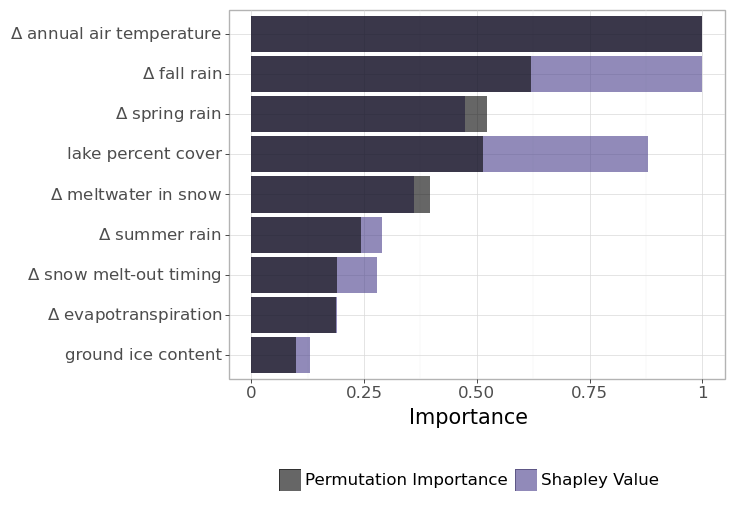

<ggplot: (2966332970945)>

In [25]:
importance_plot

In [26]:
importance_plot.save(filename = 'importance_plot.png', height=5, width=5, units = 'in', dpi=1000)

Saving 5 x 5 in image.
Filename: importance_plot.png


Export dataframe with shapley values for map figure

In [32]:
dfnew = pd.read_csv('SW_liminal_Dec17.csv')
p_20 = dfnew.SWI.quantile(0.2)
p_80 = dfnew.SWI.quantile(0.8)
dfnew = dfnew[dfnew.SWI.gt(p_80) | dfnew.SWI.lt(p_20)]
dfnew.reset_index(drop=True, inplace=True)
shapdf.reset_index(drop=True, inplace=True)

alldf = pd.concat( [shapdf, dfnew.x, dfnew.y], axis=1) 

alldf.to_csv("shap_df_May10.csv", index=False)

Create partial dependence plots

In [34]:
from sklearn.inspection import partial_dependence
def plot_pdp(model, X, feature, target=False, label=False,return_pd=False, y_pct=True, figsize=(10,9), norm_hist=True, dec=.5):
    # Get partial dependence
    pardep = partial_dependence(model, X, [feature],kind='average' )
    #percentiles=(0.02, 0.98)
    # Get min & max values
    xmin = pardep['values'][0].min()
    xmax = pardep['values'][0].max()
    ymin = pardep['average'][0].min()
    ymax = pardep['average'][0].max()+0.0001
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.grid(alpha=.5, linewidth=1)
    
    # Plot partial dependence
    color = 'darkblue'
    ax1.plot(pardep['values'][0], pardep['average'][0], color=color, linewidth=4)
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_xlabel(label, fontsize=14)
    ax1.set_ylim([ymin, ymax])
    ax1.set_ylabel(r'Marginal impact on $\Delta$ surface water', color='black', fontsize=14)
    ax1.axvline(x=0, color='black', linestyle='dashed')
    
    ax2 = ax1.twinx()
    color = 'mediumslateblue'
    ax2.hist(X[feature], bins=200, range=(xmin, xmax), alpha=.25, color=color, density=norm_hist)
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.set_ylabel('Frequency Distribution', color='black', fontsize=14)
    

    plt.savefig('fallrain_pdp.png', dpi=500)
    return plt


<module 'matplotlib.pyplot' from '/apps/python/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

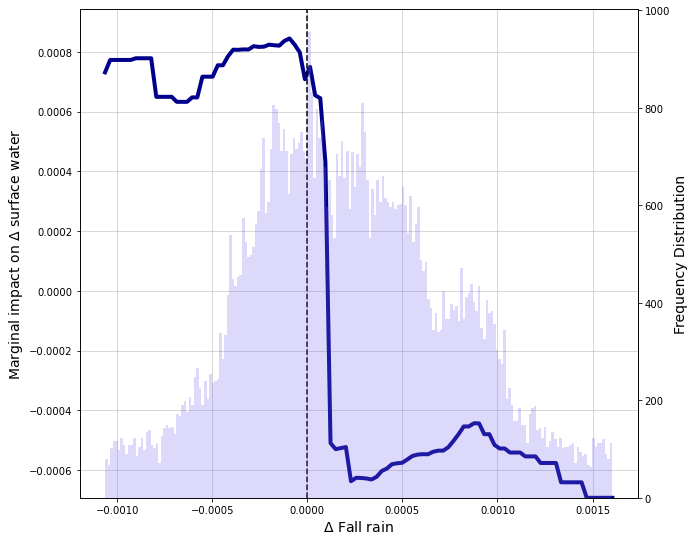

In [35]:
plot_pdp(finalmodel, x, 'fallrain', target='SWI', label=r'$\Delta$ Fall rain')


<module 'matplotlib.pyplot' from '/apps/python/3.8/lib/python3.8/site-packages/matplotlib/pyplot.py'>

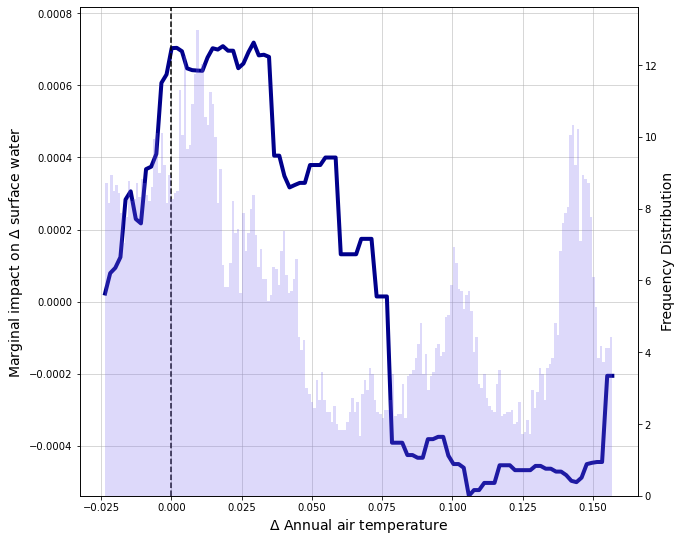

In [36]:
plot_pdp(finalmodel, x, 'annualtemp', target='SWI', label=r'$\Delta$ Annual air temperature')